In [2]:
from tensorflow import keras;
import cv2;


import numpy as np;
import os;
import random;
from matplotlib import pyplot as plt;

In [3]:
from tensorflow.keras.models import Model;
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten;
import tensorflow as tf;

In [4]:
#avoid OMM  errors by setting gpu memory consumption growth;
gpus=tf.config.experimental.list_physical_devices('GPU');
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True);

In [5]:
POS_PATH=os.path.join('data','positive');
NEG_PATH=os.path.join('data','negative');
ANC_PATH=os.path.join('data','anchor');

In [ ]:
os.makedirs(POS_PATH);
os.makedirs(NEG_PATH);
os.makedirs(ANC_PATH);

In [7]:
#uncompress the tar gz labelled faces in the wild dataset;
!tar -xf lfw.tgz


In [9]:
#move lfw images to the following repository data/negative;
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
    ex_path=os.path.join('lfw',directory,file);
    NEW_path=os.path.join(NEG_PATH,file);
    os.replace(ex_path,NEW_path);
    
    

In [10]:
import uuid

In [ ]:
cap=cv2.VideoCapture(0);
while cap.isOpened():
    
    
    ret,frame=cap.read();
     #cyt diwb frane to 250 to 2550px
    #frame=frame[75:75+255,245:245+255,:];
    frame = frame[90:340, 200:450, :]
    #collect anchors
    if cv2.waitKey(1) & 0XFF==ord('a'):
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()));
        cv2.imwrite(imgname,frame);
    
    
    #collect positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()));
        cv2.imwrite(imgname,frame);
        
    
    cv2.imshow('Image collection',frame);
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break;
    
cap.release();
cv2.destroyAllWindows();


plt.imshow(frame);

In [ ]:
plt.imshow(frame);

In [ ]:
frame.shape

In [14]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300);
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300);
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300);

In [15]:
dir_test=anchor.as_numpy_iterator();

In [16]:

print(dir_test.next());

b'data\\anchor\\e8e85ebf-944e-11ee-802a-b7c3b2187a7e.jpg'


In [17]:
#preprocessing
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path);
    img=tf.io.decode_jpeg(byte_img);
    img=tf.image.resize(img,(100,100));
    img=img/255;
    return img;
    

In [18]:
img=preprocess('data\\anchor\\edc63c41-944e-11ee-abe0-b7c3b2187a7e.jpg')

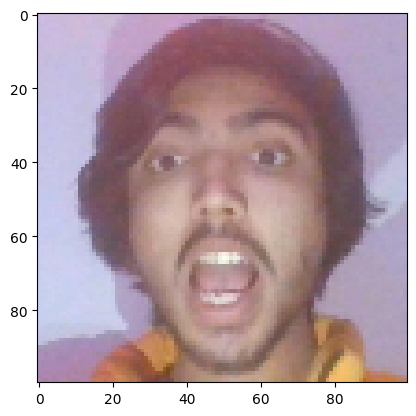

In [19]:
plt.imshow(img)

In [20]:
class_labels=tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)));

In [21]:
iterator_labs=class_labels.as_numpy_iterator();

In [22]:
print(iterator_labs.next())

0.0


In [23]:
tf.ones_like([1,1,1,4.35235,2352.5]);

In [24]:
# (anchor,positive) =>1,1,1,1,1;
# (anchor,negative) =>0,0,0,0,0;


In [25]:
#here we are creating dataset for both positive and negative with their labels as 0 or 1s;
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))));
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))));
data=positives.concatenate(negatives)

In [26]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [27]:
tf.ones(len(anchor))

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.], dtype=float32)>

In [28]:
samples=data.as_numpy_iterator();
examples=samples.next();

#here we are getting anchor input image and positive image and then label 1.

In [29]:
print(examples);

(b'data\\anchor\\ec4c54f9-944e-11ee-b1a3-b7c3b2187a7e.jpg', b'data\\positive\\6fe1b399-944f-11ee-905e-b7c3b2187a7e.jpg', 1.0)


In [30]:
#new performing preprocessing on above dataset 
def twin_preprocess(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label);

In [31]:
result=twin_preprocess(*examples);

In [32]:
print(len(result))

3


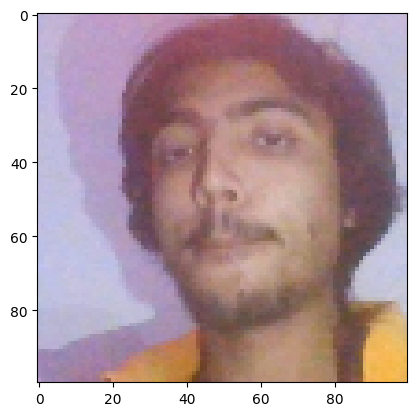

In [33]:
plt.imshow(result[1])

In [34]:
#build data loader pipeline
data=data.map(twin_preprocess);
data=data.cache();
data=data.shuffle(buffer_size=1024);

In [35]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [36]:
samples=data.as_numpy_iterator();

In [37]:
print(samples.next()[1]);

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.00392157 0.        ]
  [0.         0.00294118 0.00196078]
  [0.         0.         0.00196078]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.00392157 0.        ]
  [0.         0.00294118 0.00196078]


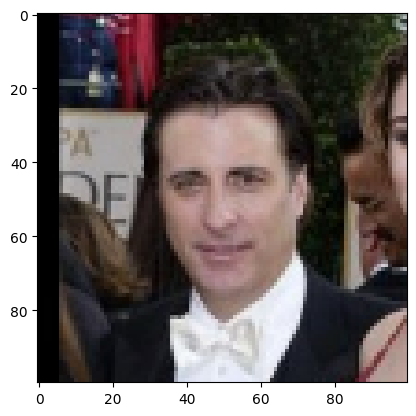

In [38]:
plt.imshow(samples.next()[1])

In [39]:
print(samples.next()[2])

0.0


In [40]:
#trainng partitions
train_data=data.take(round(len(data)*.7));
train_data=train_data.batch(16);
train_data=train_data.prefetch(8);



In [41]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [42]:
train_samples=train_data.as_numpy_iterator();
train_sample=train_samples.next();



In [43]:
len(train_sample)

3

In [48]:
#test partitions
test_data=data.skip(round(len(data)*.7));
test_data=test_data.take(round(len(data)*.3));
test_data=test_data.batch(16);
test_data=test_data.prefetch(8)

In [49]:
round(len(data)*.3)

24

In [50]:
c2=Conv2D(128,(7,7),activation='relu')(m1);
m2=MaxPooling2D(64,(2,2),padding='same')(c2);
print(m2);

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 128), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")


In [51]:
c4=Conv2D(256,(4,4),activation='relu')(m3);
print(c4)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 256), dtype=tf.float32, name=None), name='conv2d_6/Relu:0', description="created by layer 'conv2d_6'")


In [47]:
inp=Input(shape=(100,100,3),name='input_image');
c1=Conv2D(64,(10,10),activation='relu')(inp);
m1=MaxPooling2D(64,(2,2),padding='same')(c1);
print(m1);
    
#second block
c2=Conv2D(128,(7,7),activation='relu')(m1);
m2=MaxPooling2D(64,(2,2),padding='same')(c2);
print(m2);
    
#third block
c3=Conv2D(128,(4,4),activation='relu')(m2);
m3=MaxPooling2D(64,(2,2),padding='same')(c3);
print(m3);
    
#fourth block
c4=Conv2D(256,(4,4),activation='relu')(m3);
f1=Flatten()(c4);
d1=Dense(4096,activation='sigmoid')(f1);
print(d1);

KerasTensor(type_spec=TensorSpec(shape=(None, 46, 46, 64), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 128), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 128), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


# make embeddings for both anchor images and validation images

In [52]:
#build embedding layer;
def make_embeddings():
    inp=Input(shape=(100,100,3),name='input_image');
    
    #first block
    c1=Conv2D(64,(10,10),activation='relu')(inp);
    m1=MaxPooling2D(64,(2,2),padding='same')(c1);
    
     #second block
    c2=Conv2D(128,(7,7),activation='relu')(m1);
    m2=MaxPooling2D(64,(2,2),padding='same')(c2);
    
     #third block
    c3=Conv2D(128,(4,4),activation='relu')(m2);
    m3=MaxPooling2D(64,(2,2),padding='same')(c3);
    
     #fourth block
    c4=Conv2D(256,(4,4),activation='relu')(m3);
    f1=Flatten()(c4);
    d1=Dense(4096,activation='sigmoid')(f1);
    
    
    
    
    
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')
    

In [53]:
embedding=Model(inputs=[inp],outputs=[d1],name='embedding');

In [54]:
embedding.summary();

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       26

# build distance layer

In [55]:
#build distance layer
#siamese L1 Distance layer
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__();
    
    #it gives us a distance between the two images;
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding);

In [56]:
l1=L1Dist();

In [ ]:
l1(anchor_embedding,validation_embedding);

# Make siamese model

In [58]:
def siamese_model():
    #handle inputs images anchor and validation images;
    input_image=Input(name='input_img',shape=(100,100,3));
    validation_image=Input(name='validation_img',shape=(100,100,3)C
    
    #combine siamese distance components;
    siamese_layer=L1Dist();
    siamese_layer._name='distance';
    distances=siamese_layer(embedding(input_image),embedding(validation_image));
    
    #classifier layer;
    classifier=Dense(1,activation='sigmoid')(distances);
    
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')
    

In [59]:
input_image=Input(name='input_img',shape=(100,100,3));
validation_image=Input(name='validation_img',shape=(100,100,3));

In [60]:
embedding(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [61]:

inp_embedding=embedding(input_image);
val_embedding=embedding(validation_image);
print(inp_embedding);
print(val_embedding);

KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense/Sigmoid:0', description="created by layer 'embedding'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense/Sigmoid:0', description="created by layer 'embedding'")


In [62]:
siamese_layer=L1Dist();

In [63]:
distances=siamese_layer(inp_embedding,val_embedding);

In [64]:
classifier=Dense(1,activation='sigmoid')(distances);
print(classifier)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")


In [65]:
 siamese_network= Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [66]:
siamese_network.summary();

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [67]:
siamese_model=siamese_model();

siamese_model.summary();

# Define loss function and optimizers

In [68]:
binary_cross_loss=tf.losses.BinaryCrossentropy();


In [69]:
opt=tf.keras.optimizers.Adam(1e-4);


# Establish checkpoints

In [70]:
checkpoint_dir='./training_checkpoints';
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt');
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model);

In [71]:
test_batch=train_data.as_numpy_iterator();

In [72]:
batch1=test_batch.next();


In [73]:
batch1

(array([[[[0.79019606, 0.73137254, 0.85294116],
          [0.7852941 , 0.7264706 , 0.8421569 ],
          [0.79509807, 0.73039216, 0.8666667 ],
          ...,
          [0.7026961 , 0.6458333 , 0.785049  ],
          [0.70980394, 0.64705884, 0.7921569 ],
          [0.71960783, 0.6490196 , 0.7980392 ]],
 
         [[0.7892157 , 0.73039216, 0.8519608 ],
          [0.7860294 , 0.7272059 , 0.8492647 ],
          [0.7921569 , 0.73039216, 0.8686274 ],
          ...,
          [0.7058824 , 0.6509804 , 0.7882353 ],
          [0.7058824 , 0.64656866, 0.78455883],
          [0.71936274, 0.657598  , 0.79583335]],
 
         [[0.7892157 , 0.73333335, 0.8607843 ],
          [0.7897059 , 0.7323529 , 0.8625    ],
          [0.7914216 , 0.7289216 , 0.8693628 ],
          ...,
          [0.7051471 , 0.6502451 , 0.7860294 ],
          [0.70441175, 0.6495098 , 0.7794118 ],
          [0.71004903, 0.65710783, 0.7776961 ]],
 
         ...,
 
         [[0.6522059 , 0.5394608 , 0.69803923],
          [0.65196

In [74]:
batch1[2]

array([0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

In [75]:
X=batch1[:2];
X=np.array(X);
print(X.shape)

(2, 16, 100, 100, 3)


In [76]:
#definng training function process
@tf.function
def train_step(batch):
    #record all the operationss;
    with tf.GradientTape() as tape:
        X=batch[:2];
        #get label;
        y=batch[2];
    
        yhat=siamese_model(X,training=True);
        loss=binary_cross_loss(y,yhat);
    print(loss);
    grad=tape.gradient(loss,siamese_model.trainable_variables);
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables));
    return loss;
   

# BUILD TRAINING LOOP

In [77]:
def train(data,EPOCHS):
    #loop through epochs;
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS));
        progbar=tf.keras.utils.Progbar(len(data));
        #loop through each batch;
        for idx,batch in enumerate(data):
            #run train_stephere;
            train_step(batch);
            progbar.update(idx+1);
        
        #save checkpoints:
        if epoch %10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
        
    
    
    
    
    

# Train the model

In [78]:
EPOCHS=50;



In [79]:
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
4/4 [==============================] - 106s 24s/step

 Epoch 2/50
4/4 [==============================] - 77s 18s/step

 Epoch 3/50
4/4 [==============================] - 88s 22s/step

 Epoch 4/50
4/4 [==============================] - 187s 54s/step

 Epoch 5/50
4/4 [==============================] - 281s 57s/step

 Epoch 6/50
4/4 [==============================] - 244s 51s/step

 Epoch 7/50
4/4 [==============================] - 216s 51s/step

 Epoch 8/50
4/4 [==============================] - 213s 51s/step

 Epoch 9/50
4/4 [==============================] - 213s 51s/step

 Epoch 10/50
4/4 [==============================] - 164s 34s/step

 Epoch 11/50
4/4 [==============================] - 88s 21s/step

 Epoch 12/50
4/4 [==============================] - 86s 20s/step

 Epoch 13/50
4/4 [==============================] - 85

# testing the model

In [80]:
#import  metric calculatins;
from tensorflow.keras.metrics import Precision,Recall;

In [81]:
#test partitions
test_data=data.skip(round(len(data)*.7));
test_data=test_data.take(round(len(data)*.3));
test_data=test_data.batch(16);
test_data=test_data.prefetch(8)

In [144]:
#for making prediction we use this data;
# test_input will contain my anchor webcam images;
# test_Val images contain my images and other negative images;
test_input,test_val,y_true=test_data.as_numpy_iterator().next();

In [145]:
print(test_input.shape,test_val.shape,y_true.shape);

(16, 100, 100, 3) (16, 100, 100, 3) (16,)


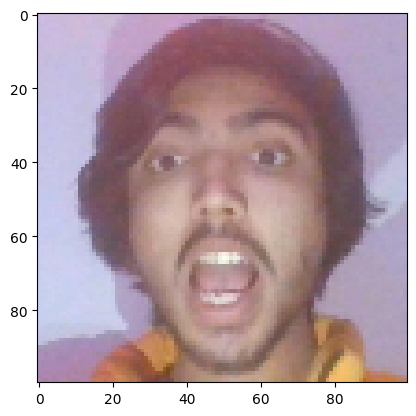

In [146]:
plt.imshow(test_input[4])

# Make predicions;


In [147]:
#make predicitons;
yhat=siamese_model.predict([test_input,test_val]);
yhat

1/1 [==============================] - 11s 11s/step


array([[1.0547853e-07],
       [9.9987310e-01],
       [1.1535529e-06],
       [9.9990612e-01],
       [9.9999750e-01],
       [1.6761999e-07],
       [9.9999827e-01],
       [9.6628100e-06],
       [9.9999708e-01],
       [3.3601779e-08],
       [1.3317203e-09],
       [3.0565770e-05],
       [9.9954271e-01],
       [1.3923559e-08],
       [1.2968753e-06],
       [2.9953071e-07]], dtype=float32)

In [148]:
print(yhat);

[[1.0547853e-07]
 [9.9987310e-01]
 [1.1535529e-06]
 [9.9990612e-01]
 [9.9999750e-01]
 [1.6761999e-07]
 [9.9999827e-01]
 [9.6628100e-06]
 [9.9999708e-01]
 [3.3601779e-08]
 [1.3317203e-09]
 [3.0565770e-05]
 [9.9954271e-01]
 [1.3923559e-08]
 [1.2968753e-06]
 [2.9953071e-07]]


In [149]:
# post processing the results;
yhat=[1 if prediction>0.5 else 0 for prediction in yhat];

In [150]:
print(yhat);

[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


In [151]:
print(y_true)

[0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]


# checking evaluation metrics

In [154]:
#Recall metrics how well we are identifying ourself from others;
m=Recall();
m.update_state(y_true,yhat);
print(m.result().numpy());
#conclusion:
#here our model is giving high recall means model is predicting me very well 100 very well from others;

1.0


In [155]:
#Precision metrics how well we are identifying the true positives; like myself;
m=Precision();
m.update_state(y_true,yhat);
print(m.result().numpy());

1.0


# Visuslizing the results;

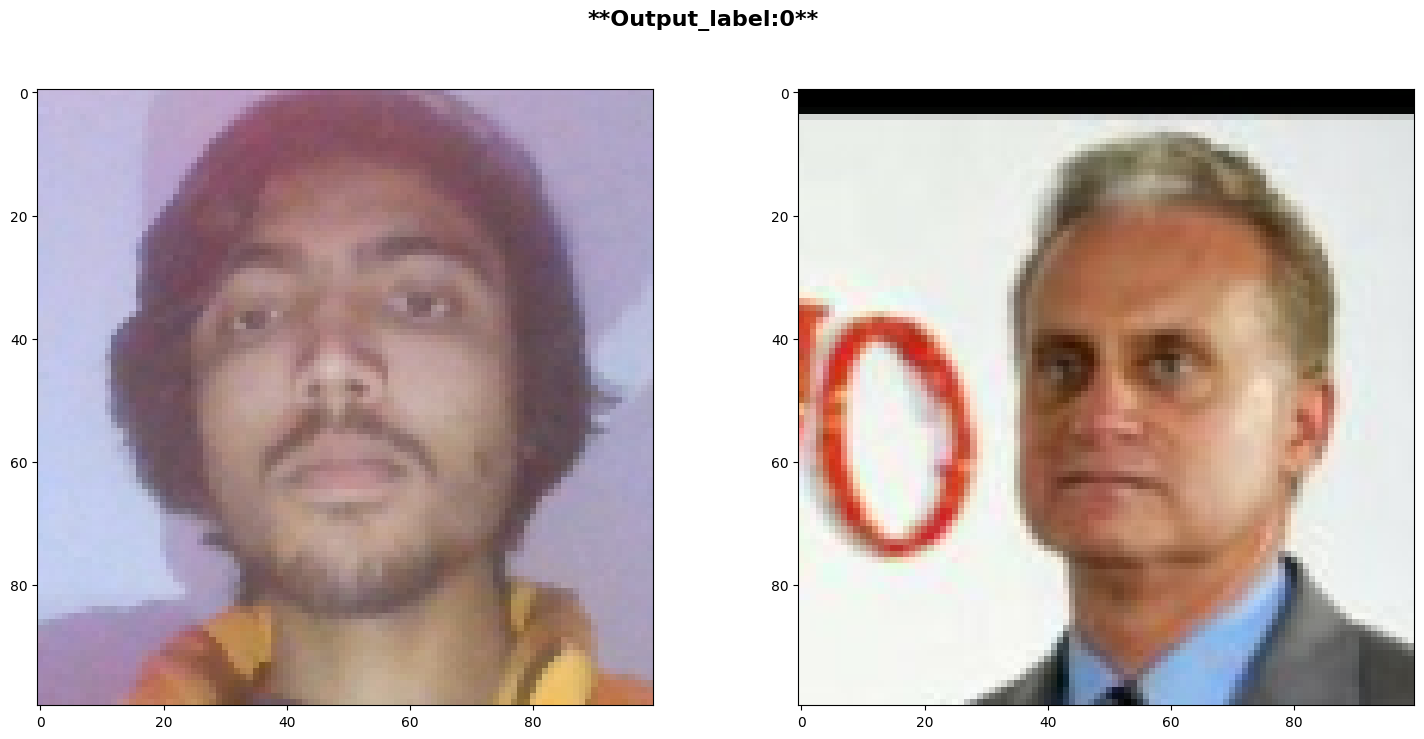

In [170]:
plt.figure(figsize=(18,8));
plt.subplot(1,2,1);
plt.imshow(test_input[7]);
plt.subplot(1,2,2);
plt.imshow(test_val[7]);
plt.suptitle(f"**Output_label:{yhat[7]}**", fontsize=16, fontweight="bold");
plt.savefig("output4.png");
plt.show();

In [171]:
siamese_model.save('siamese_model.h5');

In [173]:
#how to access  pretrained_model again we also need to load sepearte distance layer
model=tf.keras.models.load_model('siamese_model.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [174]:
#model.save() save the weights of model as well it also saves the optimizers state as well;
#save_weights() methods saves only the weights of the pretrianed model;

In [178]:
#make prediction with loaded model;
yhat=model.predict([test_input,test_val]);

1/1 [==============================] - 14s 14s/step


In [179]:
print(yhat);

[[1.0547853e-07]
 [9.9987310e-01]
 [1.1535529e-06]
 [9.9990612e-01]
 [9.9999750e-01]
 [1.6761999e-07]
 [9.9999827e-01]
 [9.6628100e-06]
 [9.9999708e-01]
 [3.3601779e-08]
 [1.3317203e-09]
 [3.0565770e-05]
 [9.9954271e-01]
 [1.3923559e-08]
 [1.2968753e-06]
 [2.9953071e-07]]


In [180]:
yhat=[1 if prediction>0.5 else 0 for prediction in yhat];

In [181]:
print(yhat)

[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


In [182]:
model.summary();

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][